## 0.Helper methods

In [1]:
""" Helper methods for loading and parsing KITTI data.
Author: Charles R. Qi
Date: September 2017
"""
from eulerangles import euler2mat
def draw_point_cloud(input_points, canvasSize=500, space=200, diameter=25,
                     xrot=0, yrot=0, zrot=0, switch_xyz=[0,1,2], normalize=True):
    """ Render point cloud to image with alpha channel.
        Input:
            points: Nx3 numpy array (+y is up direction)
        Output:
            gray image as numpy array of size canvasSizexcanvasSize
    """
    image = np.zeros((canvasSize, canvasSize))
    if input_points is None or input_points.shape[0] == 0:
        return image

    points = input_points[:, switch_xyz]
    M = euler2mat(zrot, yrot, xrot)
    points = (np.dot(M, points.transpose())).transpose()

    # Normalize the point cloud
    # We normalize scale to fit points in a unit sphere
    if normalize:
        centroid = np.mean(points, axis=0)
        points -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
        points /= furthest_distance

    # Pre-compute the Gaussian disk
    radius = (diameter-1)/2.0
    disk = np.zeros((diameter, diameter))
    for i in range(diameter):
        for j in range(diameter):
            if (i - radius) * (i-radius) + (j-radius) * (j-radius) <= radius * radius:
                disk[i, j] = np.exp((-(i-radius)**2 - (j-radius)**2)/(radius**2))
    mask = np.argwhere(disk > 0)
    dx = mask[:, 0]
    dy = mask[:, 1]
    dv = disk[disk > 0]
    
    # Order points by z-buffer
    zorder = np.argsort(points[:, 2])
    points = points[zorder, :]
    points[:, 2] = (points[:, 2] - np.min(points[:, 2])) / (np.max(points[:, 2] - np.min(points[:, 2])))
    max_depth = np.max(points[:, 2])
       
    for i in range(points.shape[0]):
        j = points.shape[0] - i - 1
        x = points[j, 0]
        y = points[j, 1]
        xc = canvasSize/2 + (x*space)
        yc = canvasSize/2 + (y*space)
        xc = int(np.round(xc))
        yc = int(np.round(yc))
        
        px = dx + xc
        py = dy + yc
        
        image[px, py] = image[px, py] * 0.7 + dv * (max_depth - points[j, 2]) * 0.3
    
    image = image / np.max(image)
    return image
def point_cloud_three_views(points):
    """ input points Nx3 numpy array (+y is up direction).
        return an numpy array gray image of size 500x1500. """ 
    # +y is up direction
    # xrot is azimuth
    # yrot is in-plane
    # zrot is elevation
    img1 = draw_point_cloud(points, zrot=110/180.0*np.pi, xrot=45/180.0*np.pi, yrot=0/180.0*np.pi)
    img2 = draw_point_cloud(points, zrot=70/180.0*np.pi, xrot=135/180.0*np.pi, yrot=0/180.0*np.pi)
    img3 = draw_point_cloud(points, zrot=180.0/180.0*np.pi, xrot=90/180.0*np.pi, yrot=0/180.0*np.pi)
    image_large = np.concatenate([img1, img2, img3], 1)
    return image_large
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def pyplot_draw_point_cloud(points, output_filename):
    """ points is a Nx3 numpy array """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #savefig(output_filename)

## 1.read airplane_0001.off to points(n x 3) and areas(m x 3)

In [2]:
import numpy as np
filename = './airplane_0001.off'
count = 0
points = []
areas = []
with open(filename, 'r') as f:
    f.readline()
    n,m,c = f.readline().rstrip().split(' ')[:]
    n = int(n)
    m = int(m)
    for i in range(n):
        value = f.readline().rstrip().split(' ')
        points.append([float(x) for x in value])
    for i in range(m):
        value = f.readline().rstrip().split(' ')
        areas.append([int(x) for x in value])
points = np.array(points)
areas = np.array(areas)
print(points.shape,points[0])
print(areas.shape,areas[0])

(90714, 3) [ 20.967  -26.1154  46.5444]
(104773, 4) [ 3 24 25 26]


In [3]:
print('mean:',np.mean(points,axis=0))
print('std:',np.std(points,axis=0))
print('diameter',np.max(np.sqrt(np.sum(abs(points)**2,axis=-1))))

mean: [ 36.46558815 -39.10308187  74.75631289]
std: [51.42173353 57.56962072 24.5251567 ]
diameter 248.3443746358069


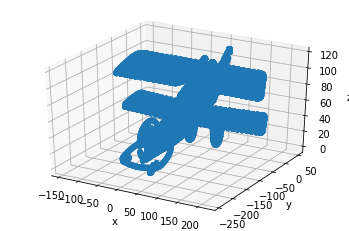

In [4]:
pyplot_draw_point_cloud(points,'points1')

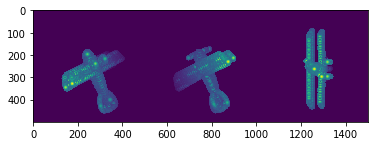

In [5]:
image_raw = point_cloud_three_views(points)
plt.imshow(image_raw)
plt.show()

In [6]:
#import cv2
#cv2.imshow("Image", image_raw) 
#cv2.waitKey (0)

## 2. normalize points to a unit sphere

In [7]:
centroid = np.mean(points, axis=0)
points_unit_sphere = points - centroid
furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
points_unit_sphere /= furthest_distance

In [8]:
print('mean:',np.mean(points_unit_sphere,axis=0))
print('std:',np.std(points_unit_sphere,axis=0))
print('diameter',np.max(np.sqrt(np.sum(abs(points_unit_sphere)**2,axis=-1))))

mean: [-5.44930919e-15 -5.15125052e-15 -1.46557823e-14]
std: [0.20705818 0.23181367 0.09875463]
diameter 0.8467821990940677


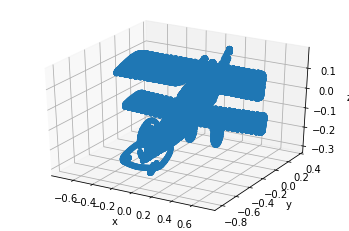

In [9]:
pyplot_draw_point_cloud(points_unit_sphere,'points_demo')

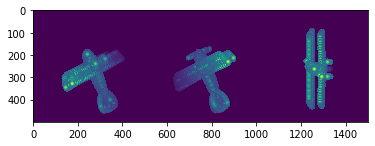

In [10]:
image_unit_sphere = point_cloud_three_views(points_unit_sphere)
plt.imshow(image_unit_sphere)
plt.show()

# 3. a wrong example using minmax normalization

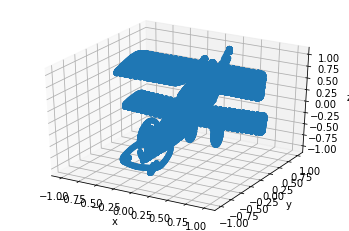

In [11]:
min_points = np.min(points,axis=0)
max_points = np.max(points,axis=0)
points_minmax = points - min_points
points_minmax /= (max_points - min_points)
points_minmax = points_minmax*2-1
pyplot_draw_point_cloud(points_minmax,'points_minmax')

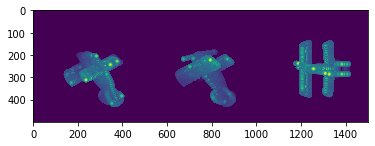

In [12]:
image_minmax = point_cloud_three_views(points_minmax)
plt.imshow(image_minmax)
plt.show()